In [340]:
import collections
import csv
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import scipy
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
from functions import data_wrangling, plot, general_func
%matplotlib inline

In [182]:
def get_perc_prescriptions(counts, total_num):
    total_great_3, total_great_4, total_great_5 = 0, 0, 0
    perc_great_3, perc_great_4, perc_great_5 = 0, 0, 0
    for key, value in counts.items():
        if key > 2:
            total_great_3 = total_great_3 + value
            perc_great_3 = total_great_3 / total_num
        if key > 3:
            total_great_4 = total_great_4 + value
            perc_great_4 = total_great_4 / total_num
        if key > 4:
            total_great_5 = total_great_5 + value
            perc_great_5 = total_great_5 / total_num
    return [perc_great_3, perc_great_4, perc_great_5, total_num]

In [292]:
date = general_func.get_todays_date()
color_palette = [['#332288', '#5B4E9F', '#9990C3', '#C1BCDB'],
                 ['#88CCEE', '#ABDBF3', '#B7E0F4', '#DBEFF9'], 
                 ['#44AA99', '#69BBAD', '#8ECCC1', '#C6E5E0'], 
                 ['#117733', '#40925B', '#88BB99', '#CFE3D6'],
                 ['#999933', '#ADAD5B', '#CCCC99', '#E0E0C1'],
                 ['#DDCC77', '#E3D692', '#EEE5BB', '#F8F4E3'], 
                 ['#CC6677', '#D68492', '#E5B2BB', '#EFD1D6'], 
                 ['#882255', '#9F4E77', '#B77A99', '#DBBCCC'], 
                 ['#AA4499', '#BB69AD', '#D4A1CC', '#E5C6E0'],
                 ['#505152', '#737374', '#A7A8A8', '#DCDCDC']]
color_palette_t = [['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499', '#505152'],
                   ['#5B4E9F', '#ABDBF3', '#69BBAD', '#40925B', '#ADAD5B', '#E3D692', '#D68492', '#9F4E77', '#BB69AD', '#737374'],
                   ['#9990C3', '#B7E0F4', '#8ECCC1', '#88BB99', '#CCCC99', '#EEE5BB', '#E5B2BB', '#B77A99', '#D4A1CC', '#A7A8A8']]

In [132]:
base_file_path = '/Users/mialydefelice/Dropbox/Personal/Consulting/2020/regional_data_analysis'
data_file_path = os.path.join(base_file_path, '030420/data')

['east_north_central',
 'east_south_central',
 'middle_atlantic',
 'mountain',
 'new_england',
 'pacific',
 'south_atlantic',
 'southeast',
 'west_north_central',
 'west_south_central']

In [178]:
#define all regions and drugs
all_regions = sorted([f for f in os.listdir(os.path.join(data_file_path, './')) if not f.startswith('.')], key=str.lower)
all_primary_drugs = ['lisinopril', 'cyclobenzaprine_hcl','budesonide',
                     'omeprazole','xalerto', 'ingrezza','digoxin','posaconazole', 'simvastatin','austedo',
                     'lovenox','vimovo','aspirin','metformin','duexis']
index = [['% > 3', '% > 4', '% > 5'], 'patients']


In [179]:
#initialize dataframe, fill in with data later
columns = pd.MultiIndex.from_product([all_primary_drugs, all_regions], names=['Drug', 'Region'])

perc_prescriptions_all = pd.DataFrame(index=index, columns=columns)
perc_prescriptions_all

Drug             lisinopril                                              \
Region   east_north_central east_south_central middle_atlantic mountain   
% > 3                   NaN                NaN             NaN      NaN   
% > 4                   NaN                NaN             NaN      NaN   
% > 5                   NaN                NaN             NaN      NaN   
patients                NaN                NaN             NaN      NaN   

Drug                                                                      \
Region   new_england pacific south_atlantic southeast west_north_central   
% > 3            NaN     NaN            NaN       NaN                NaN   
% > 4            NaN     NaN            NaN       NaN                NaN   
% > 5            NaN     NaN            NaN       NaN                NaN   
patients         NaN     NaN            NaN       NaN                NaN   

Drug                         ...             duexis                     \
Region   west_south_central  ... east_north_central east_south_central   
% > 3                   NaN  ...                NaN                NaN   
% > 4                   NaN  ...                NaN                NaN   
% > 5                   NaN  ...                NaN                NaN   
patients                NaN  ...                NaN                NaN   

Drug                                                                  \
Region   middle_atlantic mountain new_england pacific south_atlantic   
% > 3                NaN      NaN         NaN     NaN            NaN   
% > 4                NaN      NaN         NaN     NaN            NaN   
% > 5                NaN      NaN         NaN     NaN            NaN   
patients             NaN      NaN         NaN     NaN            NaN   

Drug                                                      
Region   southeast west_north_central west_south_central  
% > 3          NaN                NaN                NaN  
% > 4          NaN                NaN                NaN  
% > 5          NaN                NaN                NaN  
patients       NaN                NaN                NaN  

[4 rows x 150 columns]

In [185]:



for region in all_regions:
    save_file_path = os.path.join(base_file_path, date, region)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    condition_primary_data = []
    num_primary_patients = {}
    for drug in all_primary_drugs:
        #gather raw data, and pull out only the related drug data
        raw_data_path = os.path.join(os.path.join(data_file_path, region, 'raw_data', 'data_export_' + drug + '.csv'))
        if os.path.exists(raw_data_path):
            raw_data = pd.read_csv(raw_data_path)
            raw_data_df = data_wrangling.rename_df_cols(raw_data)
            drug_data = drug_data = raw_data_df.filter(regex='drug')
            #find the number of prescriptions each patient recieved from the ones we looked for
            num_prescriptions_per_patient = drug_data.sum(axis=1).to_list()
            prescription_counts = collections.Counter(num_prescriptions_per_patient)
            perc_prescriptions = get_perc_prescriptions(prescription_counts, len(drug_data))
            perc_prescriptions_all[drug, region] = perc_prescriptions


        #num_primary_patients[primary_split] = len(drug_data)

    #patient_fractions_export = pd.DataFrame(list(num_primary_patients.items()), columns = ['drug', 'num patients']).to_csv(os.path.join(save_file_path, region + '_patient_counts.csv'))

In [161]:
perc_prescriptions_all[drug, region] = perc_prescriptions

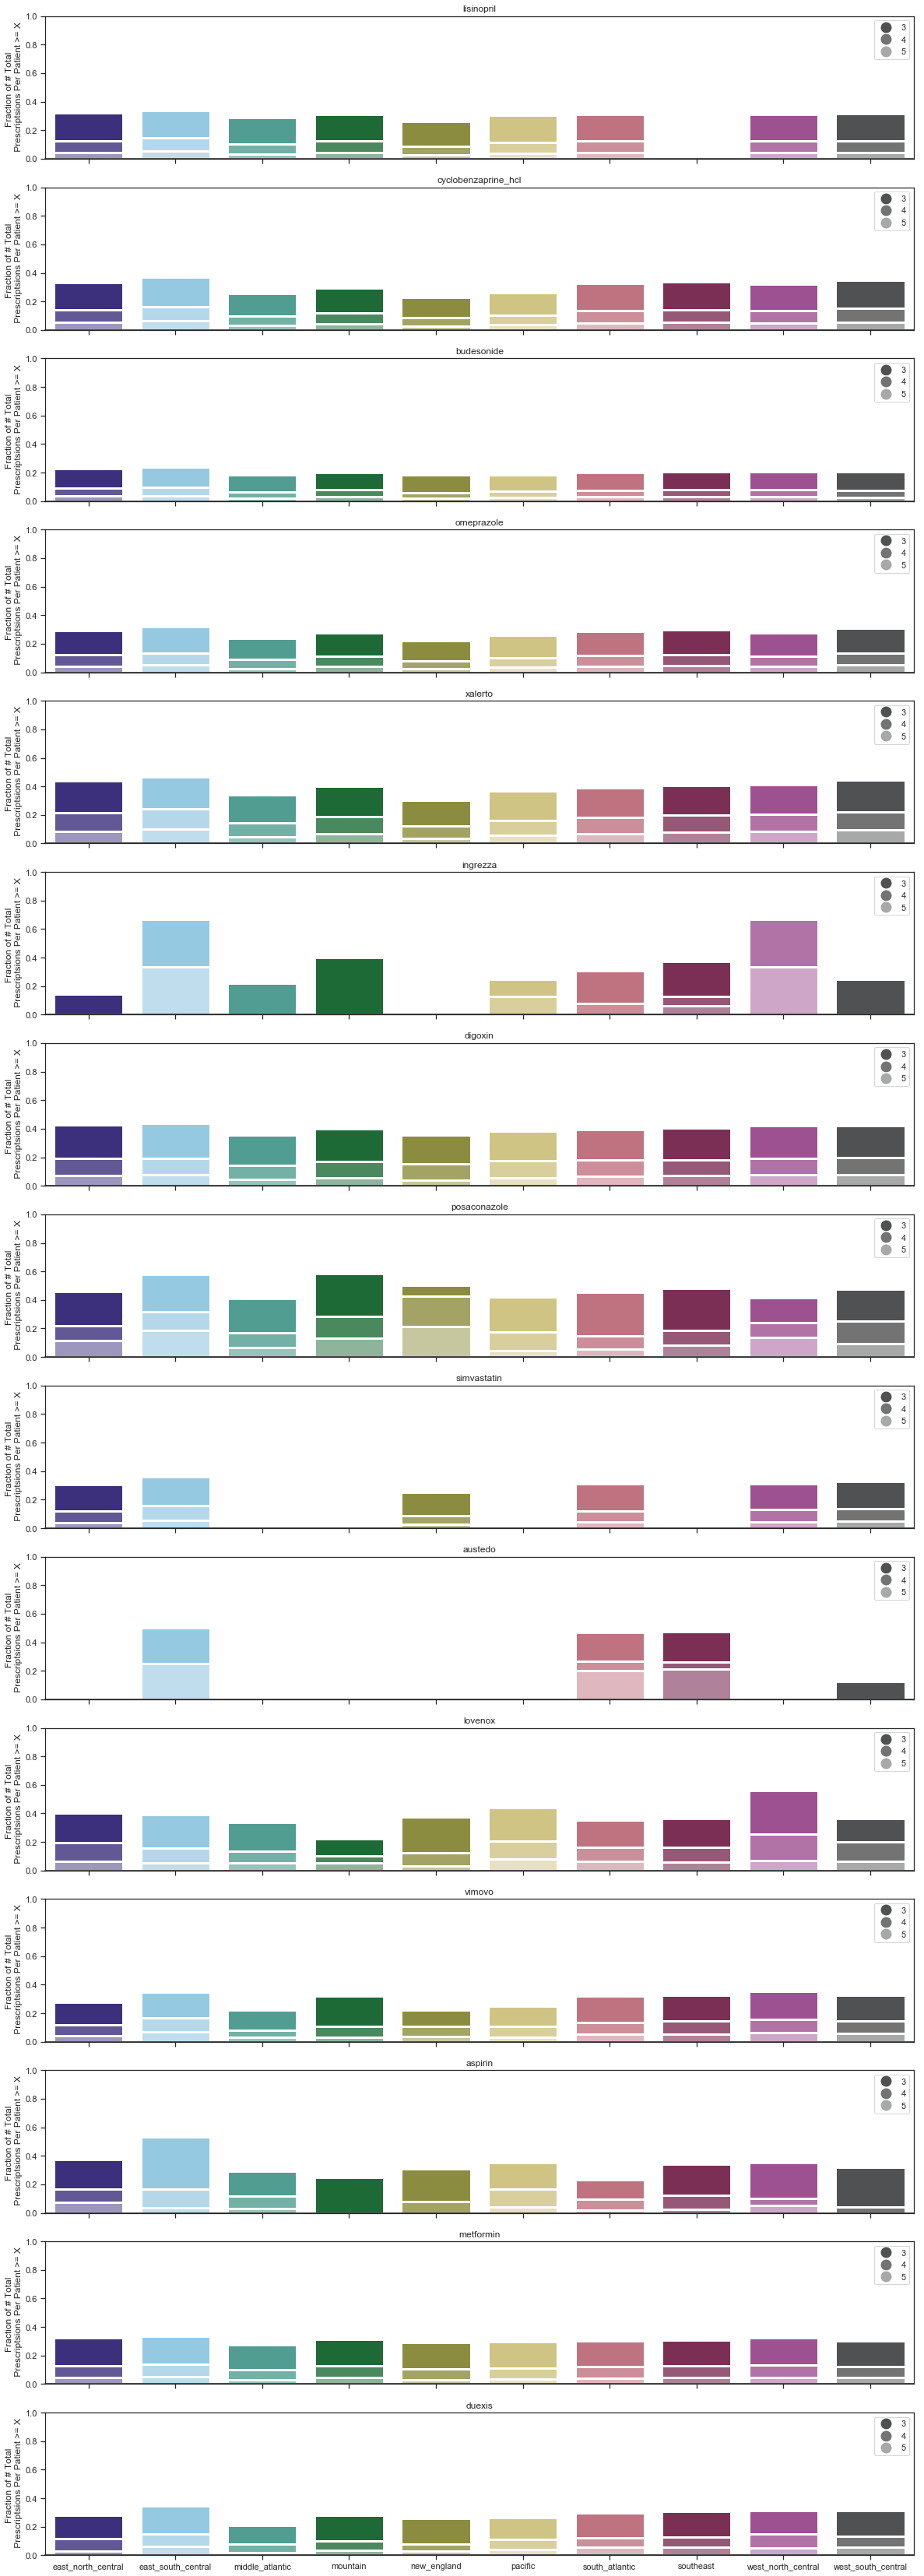

In [350]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='3',
                          markerfacecolor='#505152', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='4',
                          markerfacecolor='#737374', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='5',
                          markerfacecolor='#A7A8A8', markersize=15)]

f, ax = plt.subplots(15, 1, figsize=(20,60), sharex=True)

# Generate some sequential data
x = all_regions
count = 0
for drug in all_primary_drugs:
    y1 = perc_prescriptions_all.iloc[0][drug].to_list()
    y2 = perc_prescriptions_all.iloc[1][drug].to_list()
    y3 = perc_prescriptions_all.iloc[2][drug].to_list()

    sns.barplot(x=x, y=y1, palette=color_palette_t[0], ax=ax[count], edgecolor = '#FFFFFF', linewidth = 3)
    sns.barplot(x=x, y=y2, palette=color_palette_t[1], ax=ax[count], edgecolor = '#FFFFFF', linewidth = 3)
    sns.barplot(x=x, y=y3, palette=color_palette_t[2], ax=ax[count], edgecolor = '#FFFFFF', linewidth = 3)

    ax[count].set_title(drug)
    ax[count].axhline(0, color="k", clip_on=False)
    ax[count].set_ylim(0, 1)
    ax[count].set_ylabel("Fraction of # Total \n Prescriptsions Per Patient >= X")
    ax[count].legend(handles=legend_elements, loc='upper right')


    count += 1

plt.savefig(os.path.join(save_file_path, 'prescription_count_fractions.pdf'))


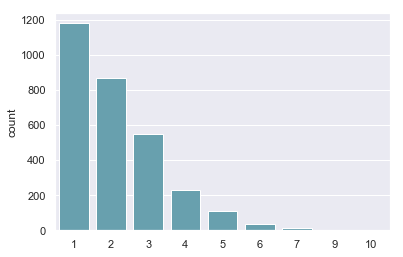

In [100]:
sns.set()
color_palette = sns.husl_palette(9, s = 0.7, h=0.6)
sns.countplot(drug_data.sum(axis=1), color = color_palette[0])